In [1]:
import numpy as np, omnical, matplotlib.pyplot as plt, mp2cal, copy

In [2]:
#wrap_data for omnical, initilize input gains as 1's
def wrap_data(npz_data):
    data = {}
    d = npz_data['data'] # d.shape = (Ntimes,Nbls,Nfreqs,Npols)
    SH = d.shape
    nt, nf = SH[0], SH[2]
    a1 = npz_data['a1'] # ant1 index, shape = Nbls
    a2 = npz_data['a2'] # ant2 index, shape = Nbls
    for ii in range(a1.size):
        bl = (a1[ii],a2[ii])
        data[bl] = {'xx': np.complex64(d[:,ii,:,0]),
                    'yy': np.complex64(d[:,ii,:,1])}
    gain = {'x':{}, 'y':{}}
    for a in np.unique(a1):
        gain['x'][a] = np.ones((nt,nf),dtype=np.complex64)
        gain['y'][a] = np.ones((nt,nf),dtype=np.complex64)
    return data, gain

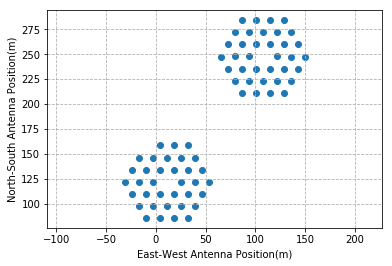

In [3]:
#Plot antenna positions, get redundant info from mp2cal
x, y = [],[]
for a in range(57,128):
    x.append(mp2cal.pos.realpos[a]['top_x'])
    y.append(mp2cal.pos.realpos[a]['top_y'])
plt.scatter(x,y)
plt.xlabel('East-West Antenna Position(m)')
plt.ylabel('North-South Antenna Position(m)')
plt.axis('equal')
plt.grid(True,linestyle='--')
plt.show()

info = mp2cal.wyl.pos_to_info(['x','y'],ex_crosspols=['xy','yx'])
reds = info.get_reds()

In [4]:
#load data, generate redundant info, run redundant calibration
d = np.load('1158518600_ORBCOMM.npz')
data, gain = wrap_data(d)
meta,sols,vis = mp2cal.wyl.run_omnical(data,info,gains0=gain, maxiter=500, conv=1e-12)

In [5]:
#Project degeneracies to the first time step.
G = mp2cal.gain.RedGain()
gref = {'x':{}, 'y':{}}
print sols['x'][57].shape
for a in sols['x'].keys(): gref['x'][a] = sols['x'][a][0]
for a in sols['y'].keys(): gref['y'][a] = sols['y'][a][0]
G.get_sky(gref)
gproj = {'x':{}, 'y':{}}
G.get_red(copy.deepcopy(sols))
G.degen_project_to_sky(time_average=False)

(27, 3)


In [6]:
# Forcing the degeneracy parameters being the same for all time steps
G = mp2cal.gain.RedGain()
gref = {'x':{}, 'y':{}}
print sols['x'][57].shape
for a in sols['x'].keys(): gref['x'][a] = sols['x'][a][0]
for a in sols['y'].keys(): gref['y'][a] = sols['y'][a][0]
G.get_sky(gref)
gproj = {'x':{}, 'y':{}}
G.get_red(copy.deepcopy(sols))
G.degen_project_to_sky(time_average=False)

(27, 3)


In [7]:
#Plot redundant visibilities in real-imaginary plane, each unique combination of color and symbol
#represent the visibilities measured by the baselines with the same length and orientation
def redplot(data, sols, polarization = 'xx', t=0, f=0):
    def unpack_ind(bl):
        i,j = bl
        pol = {0:'x', 1:'y'}
        return (i%info.nant,j%info.nant), pol[i/info.nant]+pol[j/info.nant]
    colorlist = ['red','blue','indigo','violet','cyan','sandybrown','lime','silver','gold','black','green','pink',
                 'brown','tan','bisque','magenta','darksalmon','yellow','skyblue','purple']
    markerlist = ['o','v','^','<','>','1','2','3','4','8','s','p','*','h','H','+','x','D','d','|','_']
    l0 = len(colorlist)
    l1 = len(markerlist)
    cnt = 0
    fig = plt.figure(figsize=(15,5))
    pt1 = fig.add_subplot(1,3,1)
    pt2 = fig.add_subplot(1,3,2)
    pt3 = fig.add_subplot(1,3,3)
    for r in reds:
        gp1 = []
        gp2 = []
        gp3 = []
        for bl in r:
            b,p = unpack_ind(bl)
            if p != polarization: continue
            i,j = b
            g = sols[p[0]][i][t][f]*sols[p[1]][j][t][f].conj()
            g2 = G.red[p[0]][i][t][f]*G.red[p[1]][j][t][f].conj()
            try: 
                gp1.append(data[b][p][t][f])
                gp2.append(data[b][p][t][f]/g)
                gp3.append(data[b][p][t][f]/g2)
            except:
                gp1.append(data[b[::-1]][p][t][f].conj())
                gp2.append(data[b[::-1]][p][t][f].conj()/g)
                gp3.append(data[b[::-1]][p][t][f].conj()/g2)
        gp1 = np.array(gp1)
        gp2 = np.array(gp2)
        gp3 = np.array(gp3)
        pt1.scatter(gp1.real, gp1.imag, marker=markerlist[cnt/l0], color=colorlist[cnt%l0])
        pt2.scatter(gp2.real, gp2.imag, marker=markerlist[cnt/l0], color=colorlist[cnt%l0])
        pt3.scatter(gp3.real, gp3.imag, marker=markerlist[cnt/l0], color=colorlist[cnt%l0])
        cnt += 1
    pt1.set_xticks([])
    pt2.set_xticks([])
    pt3.set_xticks([])
    pt1.set_yticks([])
    pt2.set_yticks([])
    pt3.set_yticks([])
    pt1.set_ylabel('Imaginary part')
    pt1.set_xlabel('Real part')
    pt2.set_xlabel('Real part')
    pt3.set_xlabel('Real part')
    pt1.set_title('Raw Vis')
    pt2.set_title('Post Cal')
    pt3.set_title('Post Degen Proj')
    plt.tight_layout(pad=2,w_pad=2,h_pad=2)
    plt.show()
#     plt.savefig('./images/orb'+str(t)+'.png')

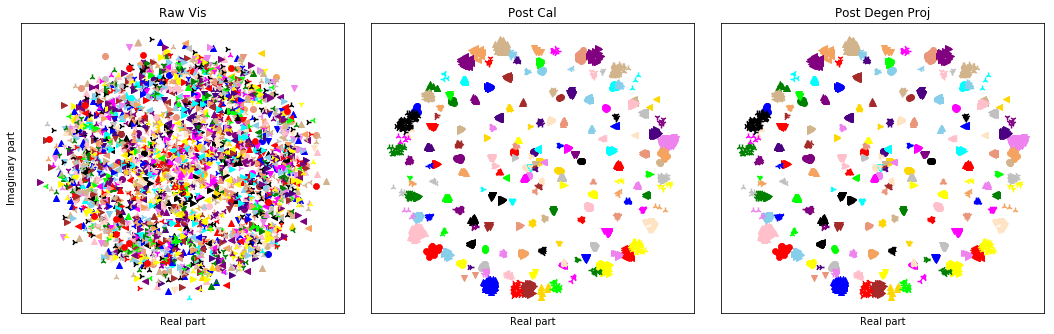

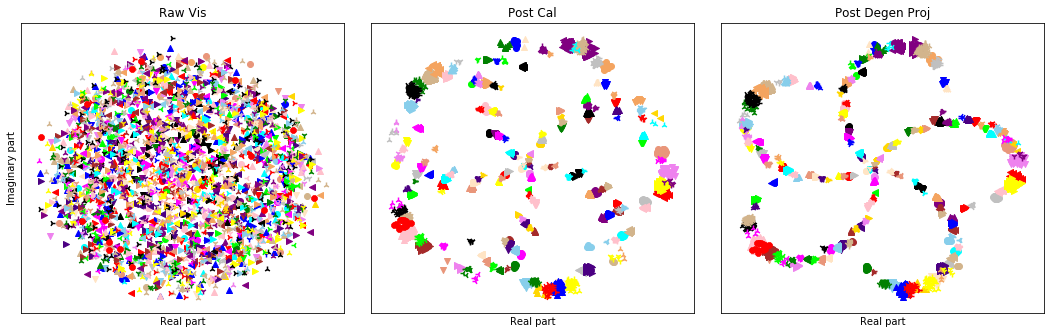

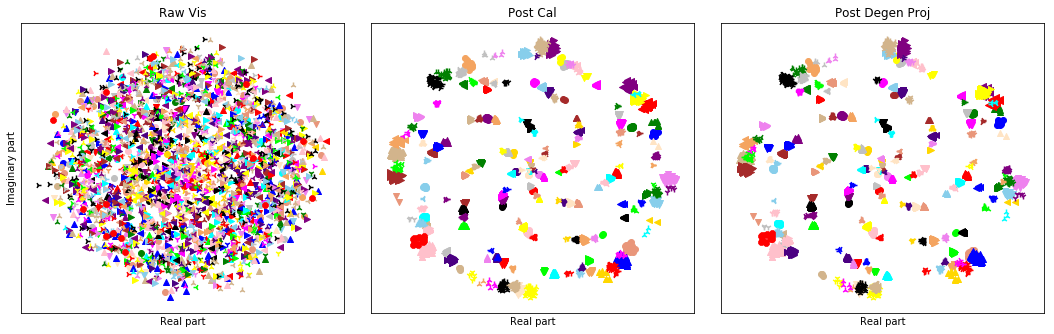

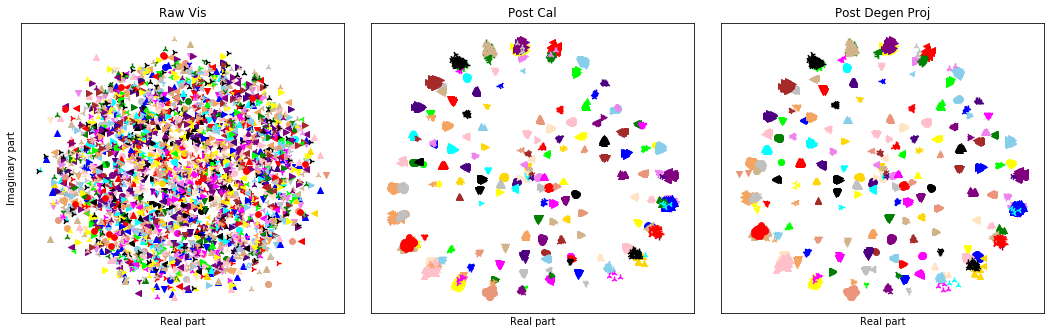

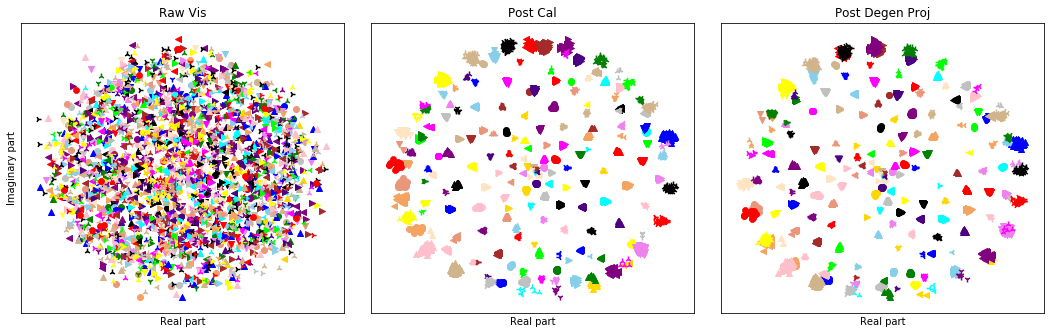

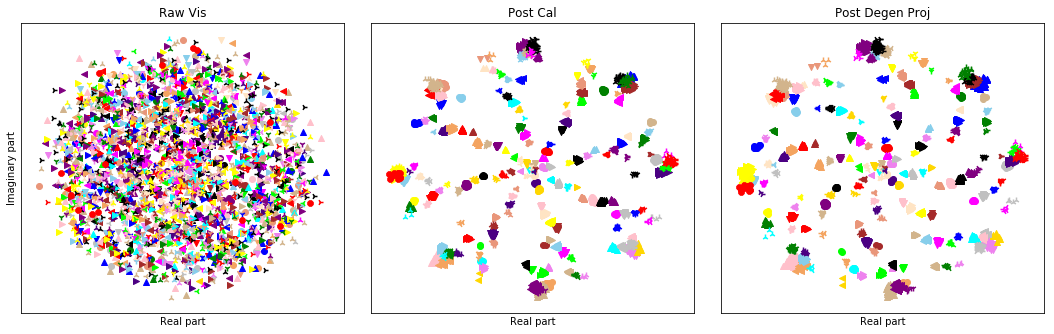

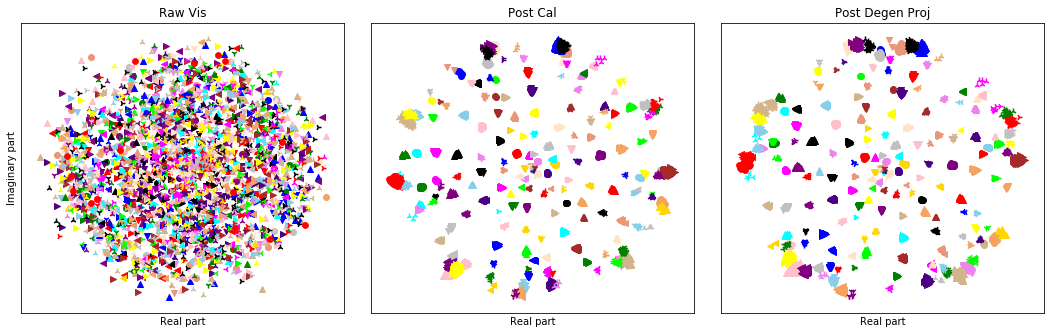

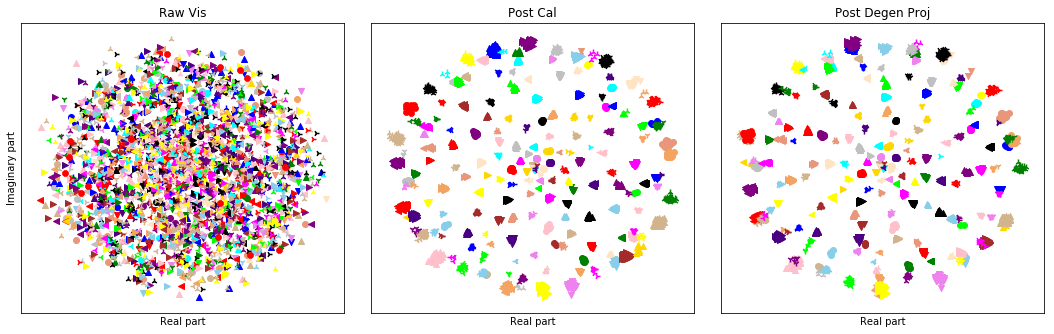

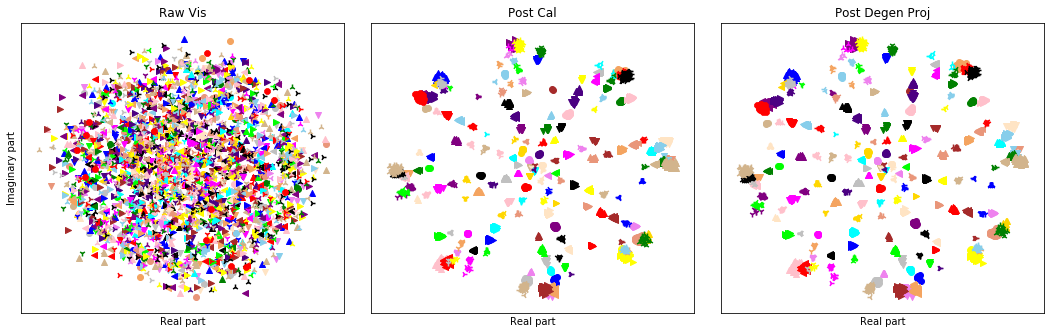

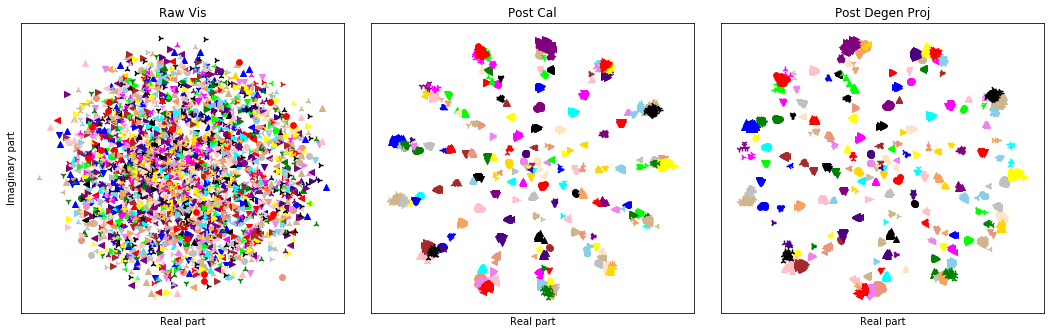

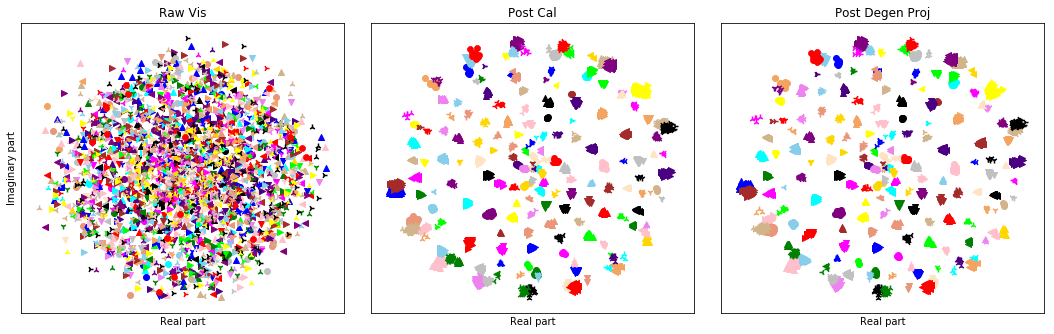

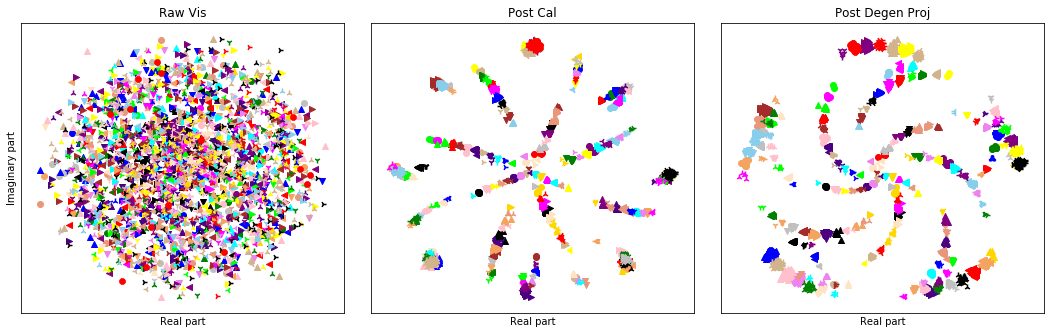

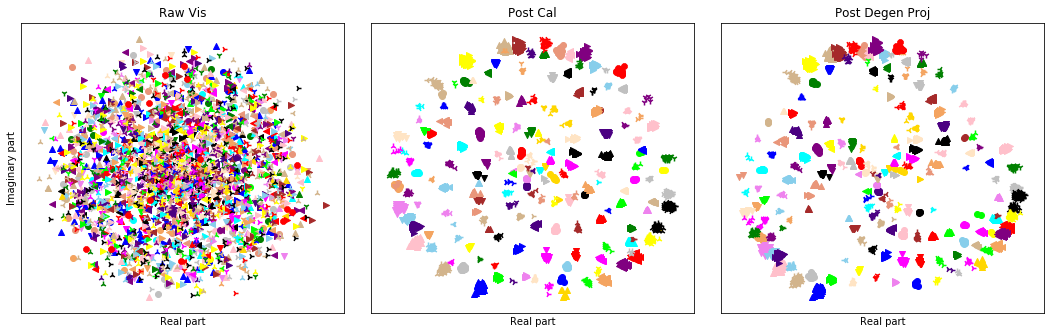

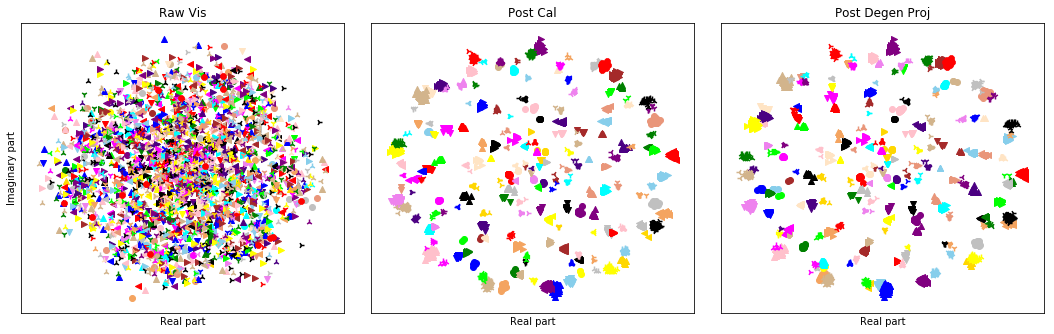

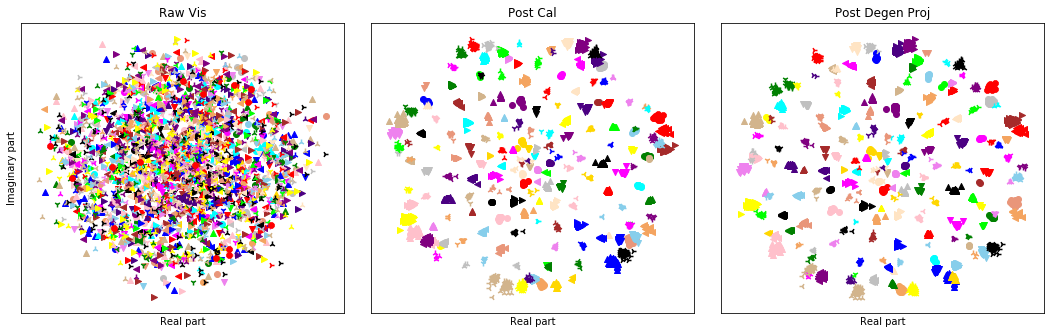

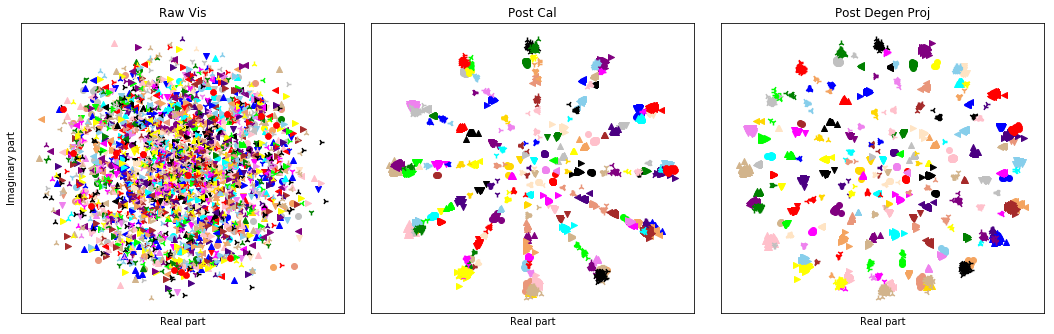

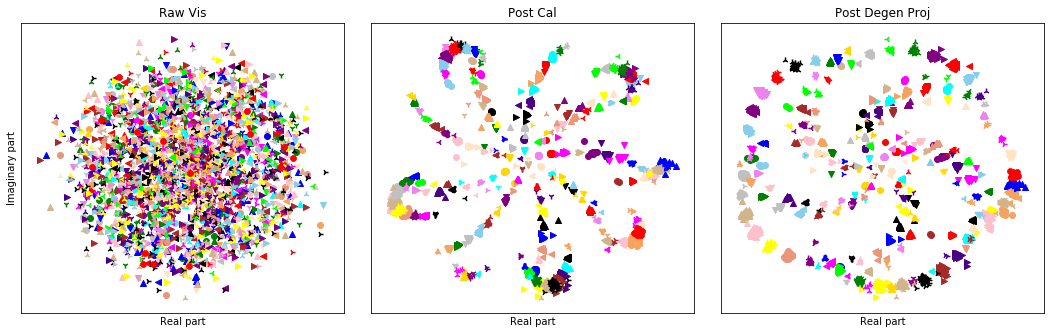

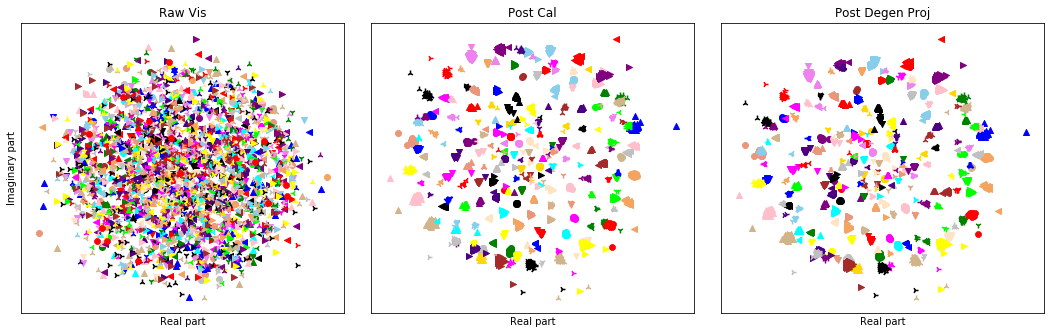

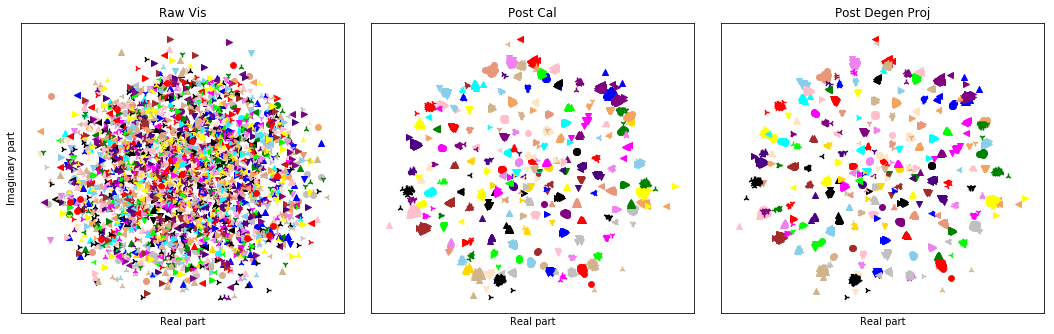

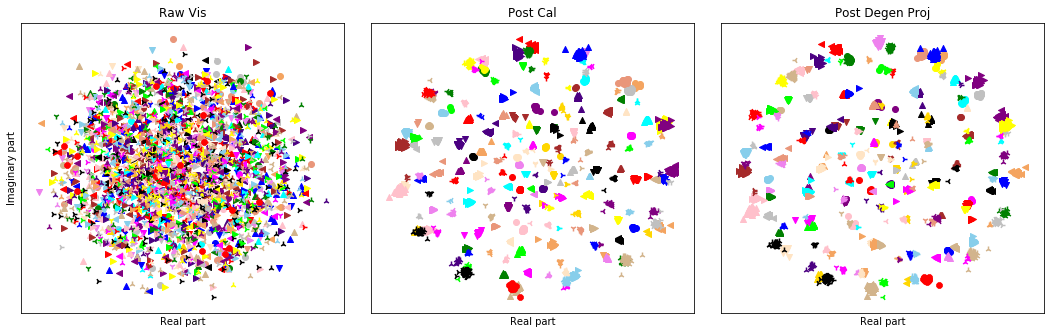

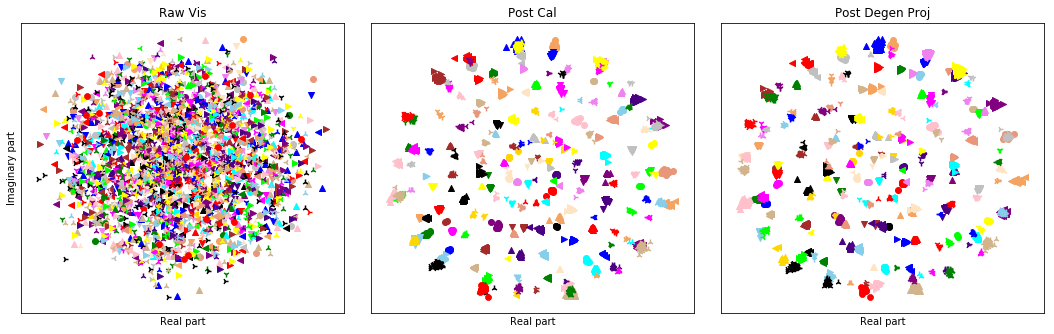

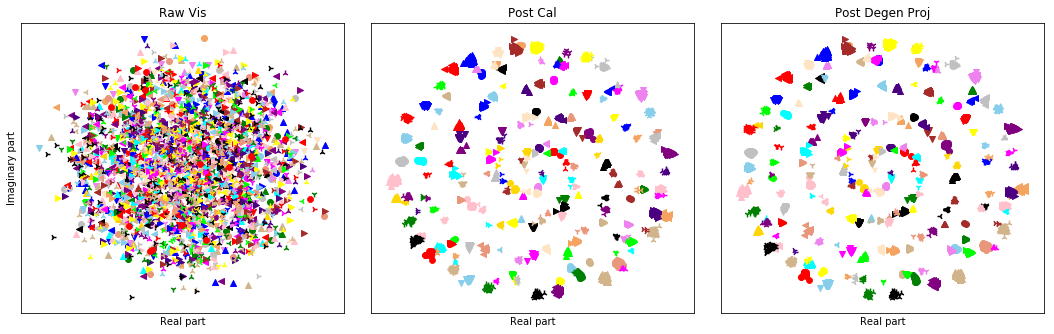

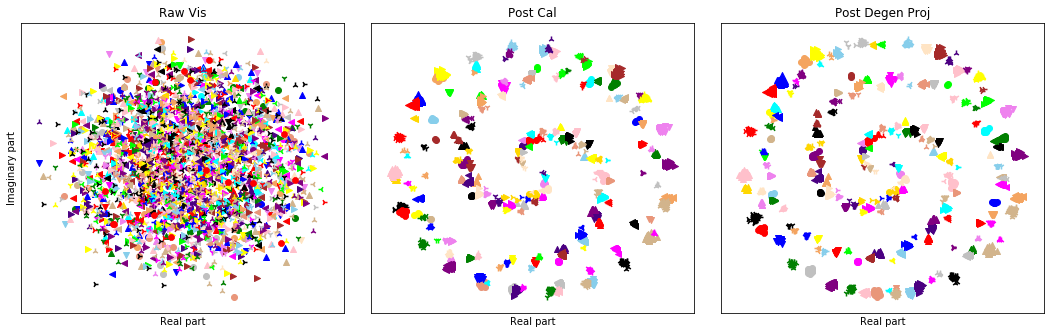

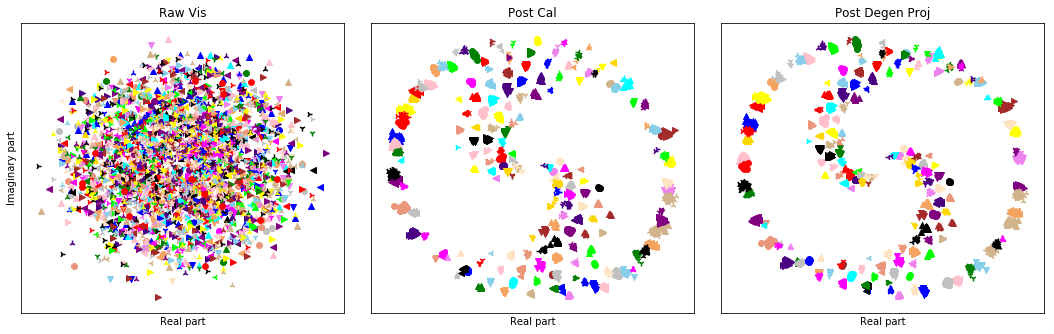

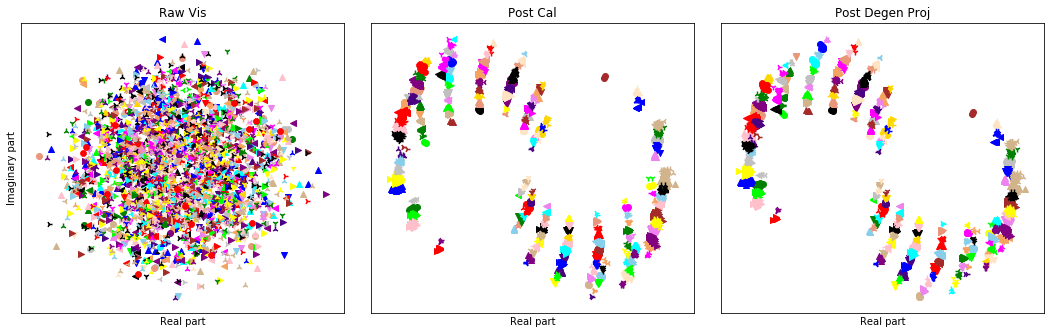

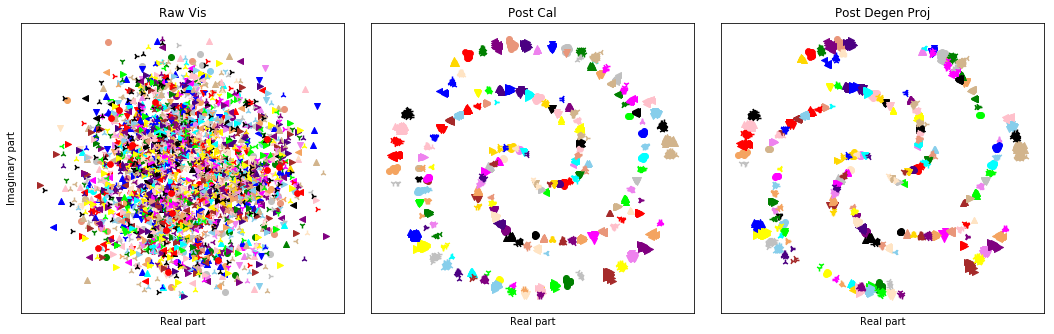

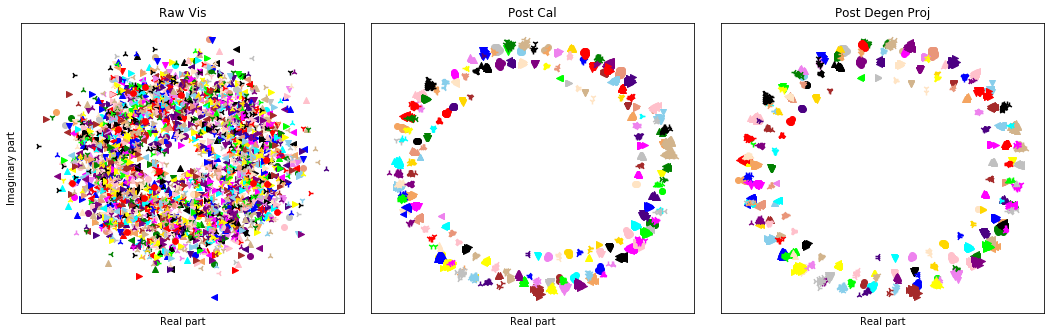

In [8]:
for t in range(0,27):
    redplot(data,sols,t=t,f=2)

In [9]:
#Track the time dependence of antenna gains.
def track_gain(p,a,f):
    fig=plt.figure()
    p1=fig.add_subplot(2,1,1)
    p1.plot(np.abs(sols[p][a][:,f]),label="raw cal")
    p1.plot(np.abs(G.red[p][a][:,f]),label="after proj degen")
    p1.set_xlabel('Time step')
    p1.set_ylabel('Amplitude')
    p1.legend()
    p2=fig.add_subplot(2,1,2)
    p2.plot(np.angle(sols[p][a][:,f]),label="raw cal")
    p2.plot(np.angle(G.red[p][a][:,f]),label="after proj degen")
#     p2.set_ylim(-np.pi,np.pi)
    p2.set_xlabel('Time step')
    p2.set_ylabel('Phase')
    p2.legend()
    plt.show()

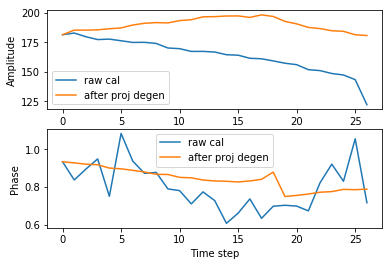

In [10]:
track_gain('x',81,2)

In [11]:
# Image the data in a naive way, i.e., with no gridding kernel
from matplotlib.colors import LogNorm
def imaging(p,t,f,imsz=101):
    fq = d['freqs'][f]
    lam = 3e8/fq
    cord = np.linspace(-1.5,1.5,imsz)
    x = np.resize(cord, (imsz,imsz))
    y = x.T
    im = np.zeros((imsz,imsz),dtype=np.complex64)
    scale = []
    for a in range(57,128):
        g = (G.red[p[0]][a][t][f]*G.red[p[1]][a][t][f].conj()).real
        scale.append(data[(a,a)][p][t][f].real/g)
#     plt.hist(scale)
#     plt.show()
    for a1 in range(57,128):
        for a2 in range(57,128):
            bl = (a1,a2)
            g = G.red[p[0]][a1][t][f]*G.red[p[1]][a2][t][f].conj()
            try: d0 = data[bl][p][t][f]
            except: d0 = data[bl[::-1]][p][t][f].conj()
            d0 /= g
            r1 = mp2cal.pos.realpos[a1]
            r2 = mp2cal.pos.realpos[a2]
            u = (r2['top_x']-r1['top_x'])/lam
            v = (r2['top_y']-r1['top_y'])/lam
            im += (d0*np.exp(1j*(u*x+v*y)))/np.mean(scale)
    im = im.real*np.exp(-2*x*x-2*y*y)
    plt.imshow(im,cmap='coolwarm',extent=(-1.5,1.5,-1.5,1.5),clim=(20,2500),norm=LogNorm())
#     plt.colorbar()
    ts = str(t)
    if(len(ts)==1): ts = '0'+ts
    plt.show()
#     plt.savefig('./images/im'+str(p)+str(f)+'-'+ts+'.png')

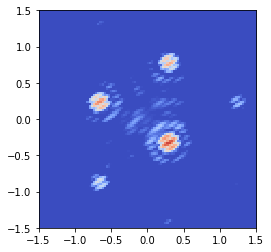

In [12]:
imaging('xx',0,2)

110.9762933715534 35.46373468942943


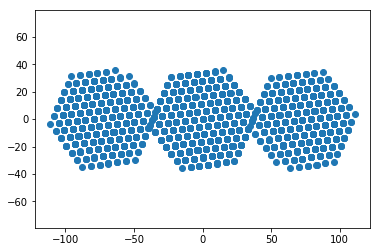

In [13]:
#Check the UV-coverage
fq = d['freqs'][2]
lam = 3e8/fq
u,v = [],[]
angle = np.exp(-1j*(np.pi/3-0.12))
for a1 in range(57,128):
    for a2 in range(57,128):
        r1 = mp2cal.pos.realpos[a1]
        r2 = mp2cal.pos.realpos[a2]
        du = (r2['top_x']-r1['top_x'])/lam
        dv = (r2['top_y']-r1['top_y'])/lam
        u.append(du*angle.real-dv*angle.imag)
        v.append(du*angle.imag+dv*angle.real)
print np.max(u),np.max(v)
plt.scatter(u,v)
plt.axis('equal')
plt.show()

In [14]:
#Gridding the UV-plane using Gaussian kernel, output the image.
def gridding(p='xx', t=[0], f=2, imsz = 101, plotw = False, uniform = False):
    cx = np.linspace(-1.5,1.5,imsz)
    cy = np.linspace(-1.5,1.5,imsz)
    im = np.zeros((len(t),imsz,imsz),dtype=np.complex64)
    fq = d['freqs'][f]
    lam = 3e8/fq
    kx = np.resize(np.linspace(-115,115,231),(81,231))
    ky = np.resize(np.linspace(-40,40,81),(231,81)).T
    uvplane = np.zeros((81,231,len(t)),dtype=np.complex64)
    weights = np.zeros((81,231))
    angle = np.exp(-1j*(np.pi/3-0.12))
    for a1 in range(57,128):
        for a2 in range(57,128):
            bl = (a1,a2)
            r1 = mp2cal.pos.realpos[a1]
            r2 = mp2cal.pos.realpos[a2]
            du = (r2['top_x']-r1['top_x'])/lam
            dv = (r2['top_y']-r1['top_y'])/lam
            u = du*angle.real-dv*angle.imag
            v = du*angle.imag+dv*angle.real
            g = G.red[p[0]][a1][t,f]*G.red[p[1]][a2][t,f].conj()
            try: d0 = data[bl][p][t,f]
            except: d0 = data[bl[::-1]][p][t,f].conj()
            d0 /= g
            w = np.exp(-((kx-u)**2+(ky-v)**2)/8.)
            weights += w
            w = np.resize(w, d0.shape+weights.shape)
            w = w.swapaxes(0,1).swapaxes(1,2)
            uvplane += d0*w
    uvplane = uvplane.swapaxes(1,2).swapaxes(0,1)
    if uniform: uvplane /= weights
    for ii in range(imsz):
        for jj in range(imsz):
            im[:,ii,jj] = np.mean(uvplane*np.exp(1j*(kx*cx[jj]+ky*cy[ii])),axis=(1,2))
    if plotw:
        plt.imshow(weights,aspect='equal',extent=(-115,115,-40,40),cmap='coolwarm')
        plt.show()
        plt.imshow(im[0].real, aspect='equal',cmap='coolwarm')
    imlist = []
    for ti in t: imlist.append(im[ti].real)
    return imlist

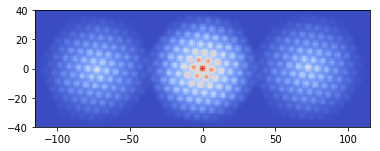

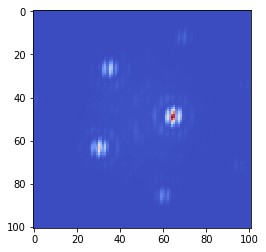

In [15]:
im = gridding(t=[0], plotw=True)

In [16]:
im = gridding(t=range(27))

<IPython.core.display.Javascript object>


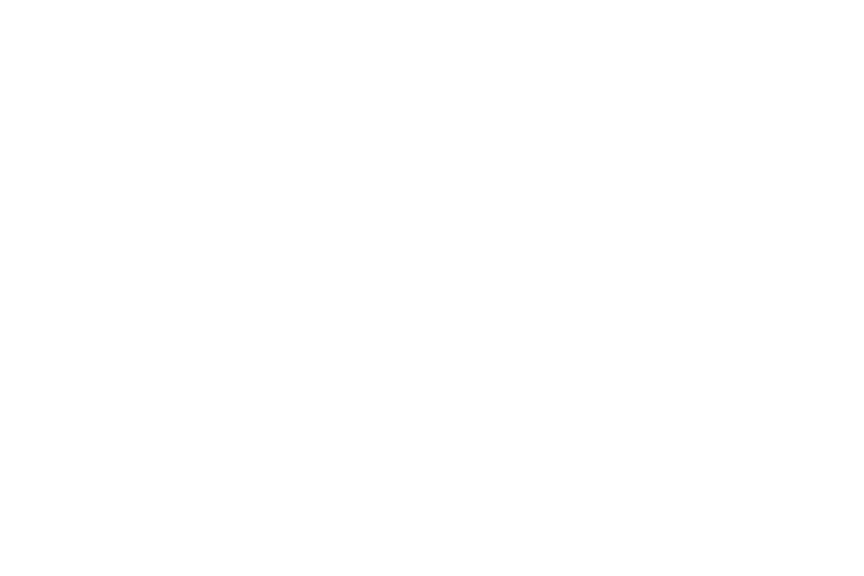

<IPython.core.display.Javascript object>


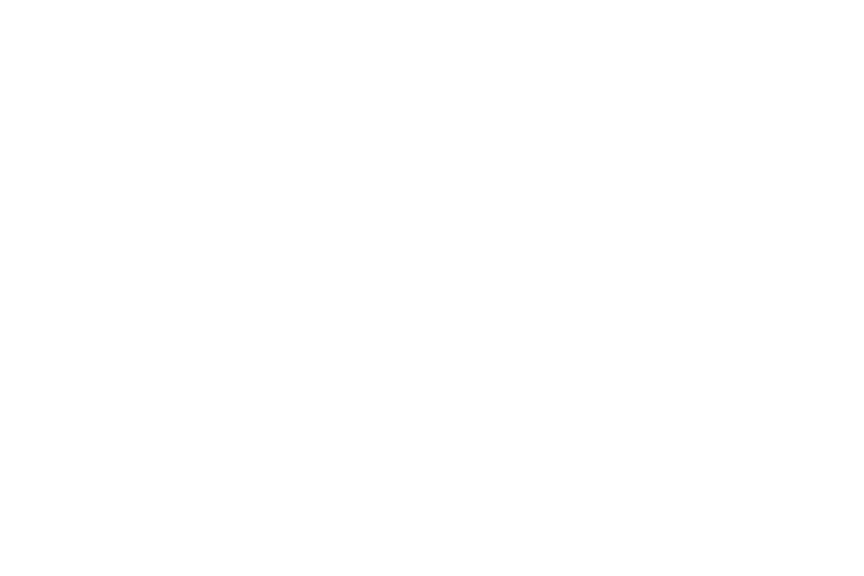

In [17]:
#Showing the movie of ORBComm drifting over the sky!!!
from matplotlib import animation, rc
%matplotlib inline
%matplotlib notebook
fig = plt.figure()
from IPython.display import HTML
images = []
for ii in range(len(im)):
    imj = plt.imshow(im[ii],aspect='equal',extent=(-1.5,1.5,-1.5,1.5),cmap='coolwarm')
    images.append([imj])
ani = animation.ArtistAnimation(fig, images, interval=200, blit=True,
                                repeat_delay=1000)
HTML(ani.to_html5_video())